Attempt to finetune SciBERT-base for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [1]:
from datasets import DatasetDict, Dataset, ClassLabel
import pandas as pd
import glob
from src.utils import map_category, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define the path to the interim data directory
data_path = "data/interim/part-*.json"
json_files = glob.glob(data_path)
papers_df = pd.concat([pd.read_json(file, lines=True) for file in json_files], ignore_index=True)

papers_df["label"] = papers_df["main_category"].apply(map_category)
papers_df["text"] = papers_df["title"] + "\n" + papers_df["summary"]
papers_df = papers_df[["text", "label"]]


In [3]:
train_df, temp_df = train_test_split(
    papers_df, 
    test_size=0.2,
    stratify=papers_df["label"],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)


In [4]:
# Print split sizes to verify
print(f"Training set: {len(train_df)} examples ({len(train_df)/len(papers_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} examples ({len(val_df)/len(papers_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} examples ({len(test_df)/len(papers_df)*100:.1f}%)")

# Check category distribution across all splits using pandas
print(f"Total categories to classify: {len(papers_df['label'].unique())}")

# Dictionary of DataFrames for easy iteration
split_dfs = {
    "train": train_df,
    "validation": val_df,
    "test": test_df
}

for split_name, df in split_dfs.items():
    # Get unique categories in this split
    split_categories = set(df["label"].unique())
    
    # Check if all categories are present
    missing_categories = set(papers_df["label"]) - split_categories
    
    print(f"\nSplit: {split_name}")
    print(f"Number of unique categories: {len(split_categories)}")
    print(f"Categories present: {len(split_categories)}/{len(papers_df['label'].unique())}")

    # Calculate and print label distribution
    print("\nLabel Distribution:")
    label_counts = df['label'].value_counts()
    label_percentages = df['label'].value_counts(normalize=True) * 100
    distribution_df = pd.DataFrame({'Count': label_counts, 'Percentage': label_percentages.round(2)})
    print(distribution_df)
    print("-" * 30) # Separator for clarity


Training set: 7121 examples (80.0%)
Validation set: 890 examples (10.0%)
Test set: 891 examples (10.0%)
Total categories to classify: 20

Split: train
Number of unique categories: 20
Categories present: 20/20

Label Distribution:
          Count  Percentage
label                      
cs         3052       42.86
math       1201       16.87
cond-mat    510        7.16
astro-ph    453        6.36
physics     451        6.33
quant-ph    326        4.58
eess        309        4.34
hep-ph      146        2.05
stat        138        1.94
gr-qc       121        1.70
hep-th      102        1.43
q-bio        54        0.76
econ         50        0.70
nucl-th      46        0.65
hep-ex       36        0.51
nlin         30        0.42
q-fin        28        0.39
math-ph      27        0.38
nucl-ex      22        0.31
hep-lat      19        0.27
------------------------------

Split: validation
Number of unique categories: 20
Categories present: 20/20

Label Distribution:
          Count  Percenta

In [5]:
# Create the final DatasetDict with train, validation, and test splits
data = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False)
})

labels = sorted(papers_df["label"].unique())
class_label = ClassLabel(names=labels)

data = data.cast_column("label", class_label)
print(data)


Casting the dataset:   0%|          | 0/7121 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/890 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/891 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7121
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 890
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 891
    })
})


In [9]:
from transformers import AutoTokenizer
model_id = "allenai/scibert_scivocab_uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)


In [10]:
data_encoded = data.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/7121 [00:00<?, ? examples/s]

Map:   0%|          | 0/890 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

In [11]:
X_train = np.array(data_encoded["train"]["text"])
X_valid = np.array(data_encoded["validation"]["text"])
y_train = np.array(data_encoded["train"]["label"])
y_valid = np.array(data_encoded["validation"]["label"])
X_train.shape, X_valid.shape


((7121,), (890,))

In [12]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [13]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [14]:
from huggingface_hub import notebook_login
notebook_login()


In [16]:
from transformers import Trainer, TrainingArguments

batch_size = 64
num_train_epochs = 2
learning_rate = 2e-5
logging_steps = len(data_encoded["train"]) // batch_size
model_name = f"{model_id}-finetuned-arxiv"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size,weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,push_to_hub=True,
                                  log_level="error")


In [29]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(data_encoded["train"]["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print the weights to see the balance
weight_dict = {data["train"].features["label"].int2str(i): w.item() for i, w in enumerate(class_weights)}
print("Class weights:")
for cls, weight in sorted(weight_dict.items()):
    print(f"{cls}: {weight:.4f}")

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_weighted_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


Class weights:
astro-ph: 0.7860
cond-mat: 0.6981
cs: 0.1167
econ: 7.1210
eess: 1.1523
gr-qc: 2.9426
hep-ex: 9.8903
hep-lat: 18.7395
hep-ph: 2.4387
hep-th: 3.4907
math: 0.2965
math-ph: 13.1870
nlin: 11.8683
nucl-ex: 16.1841
nucl-th: 7.7402
physics: 0.7895
q-bio: 6.5935
q-fin: 12.7161
quant-ph: 1.0922
stat: 2.5801


In [30]:
from transformers import Trainer
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_encoded["train"],
    eval_dataset=data_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()


/tmp/ipykernel_26146/1236485304.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.513600,0.603520,0.823596,0.811577
2,0.359200,0.611151,0.820225,0.811025


TrainOutput(global_step=224, training_loss=0.4357878001672881, metrics={'train_runtime': 295.2871, 'train_samples_per_second': 48.231, 'train_steps_per_second': 0.759, 'total_flos': 3747833257648128.0, 'train_loss': 0.4357878001672881, 'epoch': 2.0})

In [31]:
preds_output = trainer.predict(data_encoded["validation"])


In [32]:
preds_output.metrics


{'test_loss': 0.6111505031585693,
 'test_accuracy': 0.8202247191011236,
 'test_f1': 0.811025267891951,
 'test_runtime': 5.8877,
 'test_samples_per_second': 151.163,
 'test_steps_per_second': 2.378}

In [33]:
y_preds = np.argmax(preds_output.predictions, axis=1)


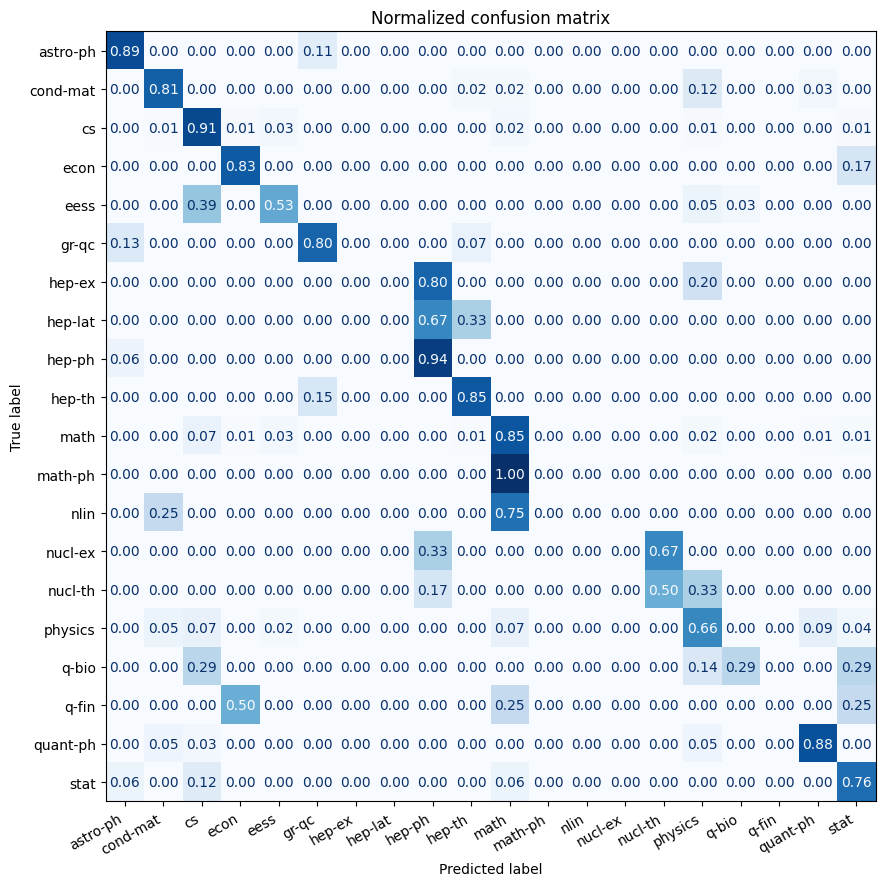

In [35]:
plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


In [ ]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [ ]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)
